In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigestSet

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'bd_analysis_results'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Classification of baited digests into BDC0, BDC1 or BDC2

In this notebook, we divide baited digests into three classes BDC0, BDC1 and BDC2 based on whether type 2 or type 3 read pairs predominate.

## Input file with interactions

The input is a file in `DiachromaticInteraction11` format created with the Python script `UICer.py`.

In [2]:
AUTHOR_SHORT = 'MON' # JAV, MIF or MON
PROTOCOL = 'CHC' # HC or CHC
CELL_TYPE_SHORT = 'IPSC' # GM12878, MK, ERY, NEU, MON, MAC_M0, ..., MESC, MFLC, MESC_R1B, CM, IPSC
OUT_PREFIX = AUTHOR_SHORT + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'
INTERACTION_FILE = '../../UICer_interactions/' + PROTOCOL + '/' + OUT_PREFIX + '_evaluated_and_categorized_interactions.tsv.gz' 

## Create  ``BaitedDigestSet``

In a `BaitedDigestSet` object, interactions are grouped by chromosomes and baits.

In [3]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)
# Create BaitedDigestSet
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../../UICer_interactions/CHC/MON_IPSC_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Set size: 812,364
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Total number of interactions read: 812,364
	[INFO] Total number of baited digests: 17,611
[INFO] ... done.
[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 812,364
	[INFO] Discarded NN and EE interactions: 84,571
	[INFO] Total number of ingested NE and EN interactions: 727,793
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] DIX: 
			[INFO] NE: 67,549
			[INFO] EN: 69,136
		[INFO] DI: 
			[INFO] NE: 146,321
			[INFO] EN: 147,882
		[INFO] UIR: 
			[INFO] NE: 145,322
			[INFO] EN: 148,881
		[INFO] UI: 
			[INFO] NE: 1,368
			[INFO] EN: 1,334
		[INFO] ALL: 
			[INFO] NE: 360,560
			[INFO] EN: 367,233
	[INFO] Total number of baited digest

## Determine frequencies of read pair types at individual baited digest

The following function determines the frequencies of read pair types for a given list of interactions. We will use this function to determine the frequencies at individual baited digests by passing a list with all interactions that are associated with a specific baited digest.

In [4]:
def get_rpt_freq_dict(interaction_list):
    
    # Initialize count dictionary returned by this function
    RPT_FREQ_DICT = dict()
    for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
        RPT_FREQ_DICT[i_cat] = dict()
        for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
            RPT_FREQ_DICT[i_cat][e_cat] = dict()
            for rp_type in ['0', '1', '2', '3']:
                RPT_FREQ_DICT[i_cat][e_cat][rp_type] = 0

    # Get frequencies of read pair types
    for d11_inter in interaction_list:
        i_cat = d11_inter.get_category()
        e_cat = d11_inter.enrichment_status_tag_pair
        for rp_type in ['0', '1', '2', '3']:
            if rp_type == '0':
                rp_count = d11_inter._simple_1
            elif rp_type == '1':
                rp_count = d11_inter._simple_2
            elif rp_type == '2':
                rp_count = d11_inter._twisted_1
            else:
                rp_count = d11_inter._twisted_2
            RPT_FREQ_DICT[i_cat][e_cat][rp_type] += rp_count
            RPT_FREQ_DICT['ALL'][e_cat][rp_type] += rp_count 
            RPT_FREQ_DICT[i_cat]['ALL'][rp_type] += rp_count 
            RPT_FREQ_DICT['ALL']['ALL'][rp_type] += rp_count
                    
    return RPT_FREQ_DICT

## Calculate baited digest score

We use the following function to calculate to calculate a score for each baited digest. We first determine the sums of read pairs for type 2 and 3. Then we divide the smaller sum by the larger sum. To avoid divisions by zero, we add a pseudo count to both sums. If the score is smaller than a chosen threshold, then we assign the baited digests to the BDC1 or BDC2 class. If the sum of type 3 read pairs is larger then we assign the digests to class BDC1 and otherwise to BDC2. If the score is greater than the threshold, we assign the baited digest to the class BDC0, which is for digests without imbalances in the configurations.

In [5]:
def get_bd_score_and_class_rpt(RPT_FREQ_DICT, bds_threshold):
    
    # Get sum of read pairs of type 2
    sum_rpt_2 = RPT_FREQ_DICT['2']

    # Get sum of read pairs of type 3
    sum_rpt_3 = RPT_FREQ_DICT['3']
    
    # Get total sum of read pairs
    sum_rpt_total = sum(RPT_FREQ_DICT.values())
    
    # Calculate imbalanced configuration score
    if sum_rpt_2 < sum_rpt_3:
        bd_score = (sum_rpt_3 + 1)/(sum_rpt_2 + 1)
        bd_class = 'BDC1'
    else:
        bd_score = (sum_rpt_2 + 1)/(sum_rpt_3 + 1)
        bd_class = 'BDC2'

    # No imbalances in the configurations
    if bd_score < bds_threshold:
        bd_class = 'BDC0'

    return bd_score, bd_class, sum_rpt_3, sum_rpt_2, sum_rpt_total

## Classify baited digests

The following code iterates over all baited digests of a `BaitedDigestSet`. For each baited digest, a list of `NE` and `EN` interactions is retrieved and the function above is used to determine the frequencies of read types. From these frequencies, we calculate a score and assign the digest either to class BDC0, BDC1 or BDC2. For each of the three classes, we create a BED file that can be loaded into UCSC's genome browser. In the browser, BDC1 class digests are shown in blue, BDC2 class digests are shown green, and BDC0 class digests are shown gray. Digest ends that are predominantly sequenced are highlighted with thick ends.

In [6]:
# If true, details are reported for each baited digests
verbose = False

# Threshold for baited digest score
bds_threshold = 2

# Interaction categories taken into account
i_cat = 'ALL'

# Directory for output
OUT_DIR = NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT
%mkdir -p $OUT_DIR

# The coordinates of baited digests of classes BDC0, BDC1 and BDC2 are written to separate BED files
BDC_FH2 = dict()
BDC_NUM_T = dict()
for bd_class in ['BDC0','BDC1','BDC2']:
    BDC_FH2[bd_class] = open(OUT_DIR + '/' + OUT_PREFIX + '_' + bd_class.lower() + '.bed', 'w')
    BDC_FH2[bd_class].write("track name=\"" + OUT_PREFIX + "_" + bd_class.lower() + "\" description=\"" + OUT_PREFIX + " " + bd_class + "\" itemRgb=\"On\"" + '\n')
    BDC_NUM_T[bd_class] = 0

# Iterate over all chromosomes
for chrom in baited_digest_set._baited_digest_dict.keys():
    
    print('Chromosome: ' + chrom)
    
    # Numbers baited digests of classes BDC0, BDC1 and BDC2 on this chromosome
    BDC_NUM_C = dict()
    for i in ['BDC0','BDC1','BDC2']:
        BDC_NUM_C[i] = 0
    
    # Iterate over all baited digests on this chromosome   
    for baited_digest_key, baited_digest in baited_digest_set._baited_digest_dict[chrom].items():
        
        # Prepare list of NE and EN interactions that belong to this baited digest 
        interaction_list = baited_digest.interactions[i_cat]['NE'] + baited_digest.interactions[i_cat]['EN']

        # Get frequencies of interactions
        RPT_FREQ_DICT = get_rpt_freq_dict(interaction_list)
        
        # Calculate score and assign to a class       
        bd_score, bd_class, sum_rpt_3, sum_rpt_2, sum_total = get_bd_score_and_class_rpt(
            RPT_FREQ_DICT[i_cat]['ALL'],
            bds_threshold)
        
        # Count baited digests of different classes
        BDC_NUM_C[bd_class] += 1
        BDC_NUM_T[bd_class] += 1
        
        # Get coordinates from key for output
        chom, sta, end = baited_digest_key.split('\t')
        
        # Format score for output
        bd_score_formatted = "{:.2f}".format(bd_score)
        
        # Write coordinates and additional information to corresponding BED files        
        name = bd_class + '|' + bd_score_formatted + ':' + str(sum_rpt_2) + ':' + str(sum_rpt_3) + ':' + str(sum_total)
        BED_line = chom + '\t' + sta + '\t' + end + '\t' + name + '\t' + bd_score_formatted + '\t' '.'
        if bd_class == 'BDC0':
            BED_line += '\t' + sta + '\t' + sta + '\t' + '128,128,128' + '\n'
        elif bd_class == 'BDC1':
            BED_line += '\t' + sta + '\t' + str(int(sta)+100) + '\t' + '0,0,100' + '\n'
        elif bd_class == 'BDC2':
            BED_line += '\t' + str(int(end)-100) + '\t' + end + '\t' + '0,100,0' + '\n'
        else:
            print('[ERROR] Invalid class ID: ' + bd_class + '!')
        BDC_FH2[bd_class].write(BED_line)
    
        # Output details about each individual baited digest            
        if verbose:
            print('-------------------------')
            print(baited_digest_key)
            print('sum_rpt_2: ' + str(sum_rpt_2))
            print('sum_rpt_3: ' + str(sum_rpt_3))
            print('sum_total: ' + str(sum_total))
            print('bd_class: ' + bd_class)            
            print('bd_score: ' + bd_score_formatted)
            print()
            for rp_type in ['0', '1', '2', '3']:
                for e_cat in ['ALL', 'NE','EN']:
                    print(i_cat + '-' + e_cat + '-' + rp_type + ': ' + str(RPT_FREQ_DICT[i_cat][e_cat][rp_type]))
                print()
                
    print('\tNumber of baited digests: ' + "{:,}".format(sum(BDC_NUM_C.values())))
    for bd_class in ['BDC0','BDC1','BDC2']:
        print('\t\t' + bd_class  + ": {:,}".format(BDC_NUM_C[bd_class]))

print()
print('Total number of baited digests: ' + "{:,}".format(sum(BDC_NUM_T.values())))
for bd_class in ['BDC0','BDC1','BDC2']:
    print('\t' + bd_class  + ": {:,}".format(BDC_NUM_T[bd_class]))
    BDC_FH2[bd_class].close()

Chromosome: chr2
	Number of baited digests: 1,089
		BDC0: 171
		BDC1: 450
		BDC2: 468
Chromosome: chr14
	Number of baited digests: 577
		BDC0: 89
		BDC1: 243
		BDC2: 245
Chromosome: chr9
	Number of baited digests: 658
		BDC0: 104
		BDC1: 288
		BDC2: 266
Chromosome: chr6
	Number of baited digests: 977
		BDC0: 174
		BDC1: 400
		BDC2: 403
Chromosome: chr13
	Number of baited digests: 274
		BDC0: 43
		BDC1: 117
		BDC2: 114
Chromosome: chr8
	Number of baited digests: 553
		BDC0: 78
		BDC1: 220
		BDC2: 255
Chromosome: chr7
	Number of baited digests: 769
		BDC0: 119
		BDC1: 340
		BDC2: 310
Chromosome: chr4
	Number of baited digests: 635
		BDC0: 93
		BDC1: 290
		BDC2: 252
Chromosome: chr15
	Number of baited digests: 581
		BDC0: 105
		BDC1: 237
		BDC2: 239
Chromosome: chr12
	Number of baited digests: 979
		BDC0: 157
		BDC1: 397
		BDC2: 425
Chromosome: chr1
	Number of baited digests: 2,094
		BDC0: 379
		BDC1: 875
		BDC2: 840
Chromosome: chr11
	Number of baited digests: 1,179
		BDC0: 189
		BDC1: 5

## Overlaps of baited fragments from classes BDC0, BDC1 and BDC2

### Select dataset

In [7]:
AUTHOR_SHORT = 'SCH'
CT_LIST = ['MESC', 'MFLC', 'MESC_R1B']
IN_DIR = NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT

In [17]:
AUTHOR_SHORT = 'JAV'
CT_LIST = ['MK', 'ERY', 'NEU', 'MON', 'MAC_M0', 'MAC_M1', 'MAC_M2', 'EP', 'NB', 'TB', 'FOET', 'NCD4', 'TCD4', 'NACD4', 'ACD4', 'NCD8', 'TCD8']
IN_DIR = NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT

In [13]:
AUTHOR_SHORT = 'MON'
CT_LIST = ['IPSC', 'CM']
IN_DIR = NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + AUTHOR_SHORT

### Read baited fragments from files into data structure

We generate a set of coordinates from each file. Each set can be accessed by cell type and BD class.

In [18]:
bd_dict = dict()
for ct in CT_LIST:
    bd_dict[ct] = dict()
    for bdc in ['0', '1', '2']:
        f_name = IN_DIR + '/' + AUTHOR_SHORT + '_' + ct + '_CHC_REPC' +'_bdc' + bdc + '.bed'
        #print('Reading file: ' + f_name)
        d_set = set()
        with open(f_name) as fh:
            next(fh) # discard header line
            for line in fh:
                fields = line.rstrip().split('\t')
                d_key = fields[0] +':' + fields[1] + '-' + fields[2]
                d_set.add(d_key)
        #print('\tNumber of digests: ' + str(len(d_set)))
        bd_dict[ct][bdc] = d_set

### Get fraction of overlapping fragments for each pair of fragment sets

In [64]:
isect_prop_list = []
for BDC_A in ['0', '1', '2']:
    for CT_A in CT_LIST:
        col_names = []
        for BDC_B in ['0', '1', '2']:
            for CT_B in CT_LIST:
                isect_size = len(bd_dict[CT_A][BDC_A] & bd_dict[CT_B][BDC_B])
                set_A_size = len(bd_dict[CT_A][BDC_A])
                isect_prop_list.append(isect_size/set_A_size)
                col_names.append(CT_B + '-BFC' + BDC_B)

# Transform list to matrix and set row and column names
isect_prop_matrix = np.reshape(isect_prop_list, (-1, len(col_names)))
isect_prop_df = pd.DataFrame(data=isect_prop_matrix, columns=col_names)
isect_prop_df.index = col_names
#isect_prop_df

### Create heatmap for overlap portions

Note that this heatmap is not symmetrical and should be read as follows. A box in row `i` and column `j` indicates the proportion of fragments in set `i` that occur in both sets `i` and `j`.

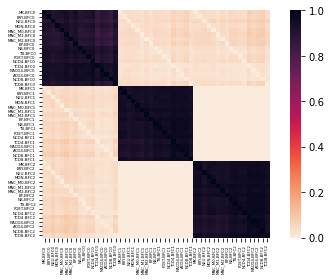

In [52]:
cm = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(isect_prop_df, square=True, cmap=cm, xticklabels=True, yticklabels=True)
plt.tick_params(axis='both', which='major', labelsize=4)
plt.tight_layout()
plt.savefig(IN_DIR + '/' + AUTHOR_SHORT + '_bdc_heatmap.pdf', bbox_inches='tight')

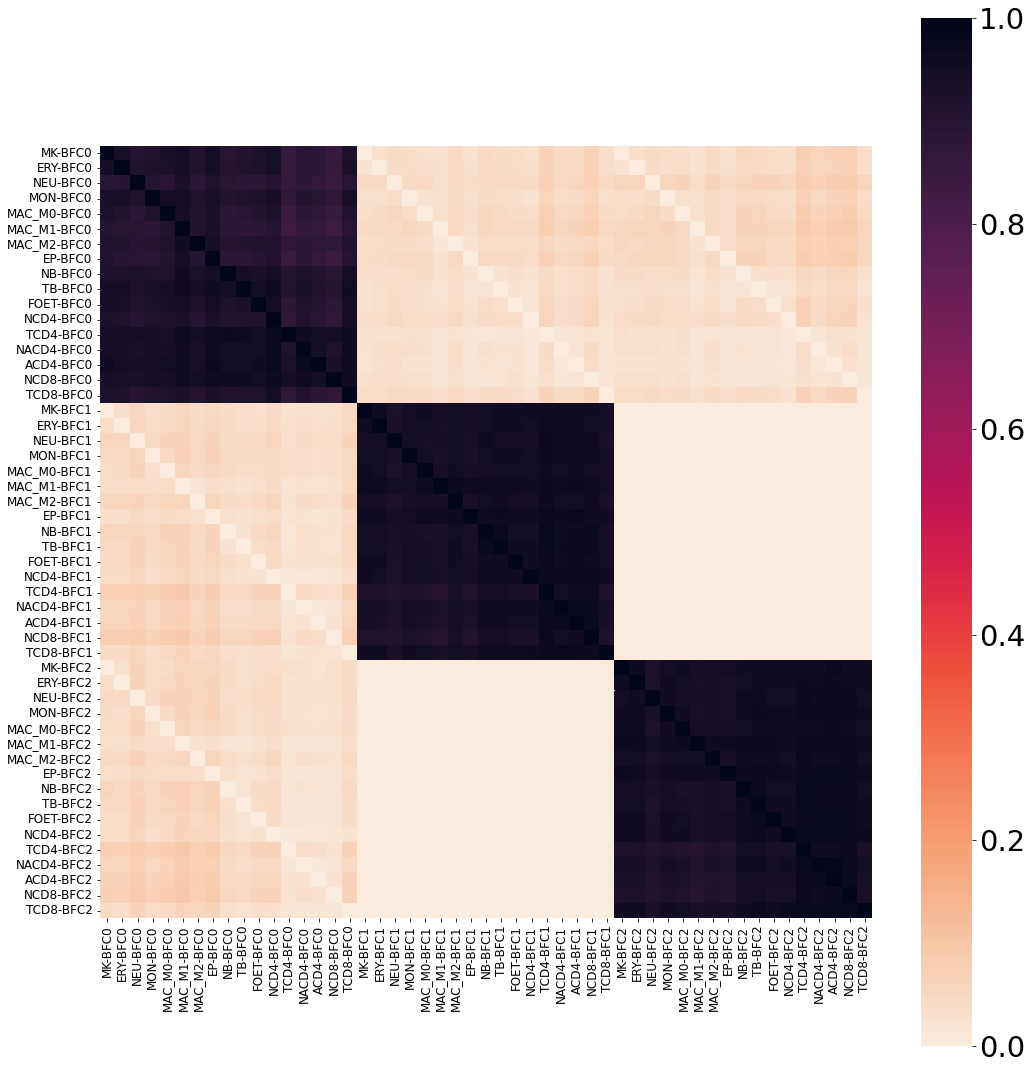

In [75]:
fig, ax = plt.subplots(figsize=(15,15))
cm = sns.color_palette("rocket_r", as_cmap=True)
ax = sns.heatmap(isect_prop_df, square=True, cmap=cm, xticklabels=True, yticklabels=True)
ax.tick_params(labelsize=12)
ax.figure.axes[-1].tick_params(labelsize=29)
plt.tight_layout()
plt.savefig(IN_DIR + '/' + AUTHOR_SHORT + '_bdc_heatmap.pdf', bbox_inches='tight')